In [1]:
# ! pip install numpy
# ! pip install matplotlib

## Q-learning и SARSA

### Описание МППР + модель среды

Будем моделировать случайную лесную среду

Необходимо моделировать
- препятствия
- труднопроходимую поверхность (грязь, вода, болото, ветки и пр.)

Цель - добраться из точки A в точку B

Считаем, что среда - GridWorld - ограниченный прямоугольник, разбитый на клетки  
Пусть в каждой клетке сетки находится целое число $x$

Каждая клетка может быть:
- пустой: $x = 0$
- содержать препятствие: $x = 10$
- быть труднопроходимой поверхностью с некоторым коэффициентом проходимости: $1 \le x \le 9$

Смысл значения $x$ (**динамика среды**): при попытке перехода агента из текущей клетки со значением $x$
- с вероятностью $\frac{x}{10}$ агент остаётся в своей текущей клетке
- с вероятностью $1 - \frac{x}{10}$ агент выполняет переход

НО: если агент пытается перейти в клетку с препятствием $x = 10$ или за границы сетки, переход не выполняется никогда

**Состояние** - $(\Delta i, \Delta j, x_{cur}, x_{up}, x_{down}, x_{left}, x_{right})$

- $\Delta i, \Delta j$ - разность координат до цели - могут быть отрицательные - чтобы понять, где агент относительно цели
- $x$ - значения проходимости в текущей клетке и по соседним - т.е. агент видит, что происходит в текущей клетке и в соседних

*если соседняя клетка - граница прямоугольника - она считается препятствием ($x = 10$)*

**Действия**:
- шаг вверх
- шаг вниз
- шаг вправо
- шаг влево

**Вознаграждения:**
- -1 за один шаг (не важно, случился переход или нет)
- +50 за финиш

### Проблема!

Уже для сетки 5x5 количество возможных состояний $= 9 \cdot 9 \cdot 11 \cdot 11 \cdot 11 \cdot 11 \cdot 11 = 13045131$

Табличные методы не в состоянии за разумное время посчитать функцию ценности для всех состояний.

Поэтому предложим другое состояние для Q-learning и SARSA:

$(sgn(\Delta i), sgn(\Delta j), x'_{cur}, x'_{up}, x'_{down}, x'_{left}, x'_{right})$, где
- $sgn(\Delta i), sgn(\Delta j)$ - направление по обеим координатам до цели (-1, 0, 1)
- $x'$ - значение проходимости в текущей клетке и по соседям (0 - пустая клетка, 1 - труднопроходимая поверхность, 2 - препятствие или стена)

Тем самым уменьшим количество состояний до $3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 \cdot 3 = 2187$

In [2]:
import random
from random import randint
from numpy.random import choice
from collections import deque
from math import sqrt

OBSTACLE = 10
MAX_SWAMP = 9
STEPS = [(-1, 0), (1, 0), (0, -1), (0, 1)]

def generate_environment(n, m, p_walk, p_obstacle, number_mud):
    # Находится ли точка внутри сетки
    def in_grid(i, j):
        return 0 <= i < n and 0 <= j < m

    # Возвращает манхеттенское расстояние между (i1, j1) и (i2, j2)
    def dist(i1, j1, i2, j2):
        return abs(i1 - i2) + abs(j1 - j2)

    def random_point():
        return (randint(0, n-1), randint(0, m-1))

    grid = [[-1] * m for _ in range(n)]
    start = random_point()
    finish = random_point()

    # --- Генерация случайного пути между стартом и финишем ---

    i, j = start
    fi, fj = finish

    while (i, j) != (fi, fj):
        grid[i][j] = 0
        # С вероятностью p_walk делаем шаг в случайную сторону (равновероятно)
        if choice([0, 1], p=[1 - p_walk, p_walk]):
            di, dj = random.choice(STEPS)
            ni, nj = i + di, j + dj
            if in_grid(ni, nj):
                i, j = ni, nj
        # С вероятностью 1 - p_walk - шаг в направлении финиша
        else:
            options = []
            for di, dj in STEPS:
                ni, nj = i + di, j + dj
                if in_grid(ni, nj) and dist(ni, nj, fi, fj) < dist(i, j, fi, fj):
                    options.append((ni, nj))

            i, j = random.choice(options)

    grid[fi][fj] = 0

    # --- Генерация препятствий ---

    for i in range(n):
        for j in range(m):
            # Нельзя поставить препятствие на пути из старта в финиш
            # В остальных клетках - с вероятностью p_obstacle
            if grid[i][j] == -1 and choice([0, 1], p=[1 - p_obstacle, p_obstacle]):
                grid[i][j] = OBSTACLE

    # --- Генерация труднопроходимых поверхностей ---

    for _ in range(number_mud):
        # Случайная точка - центр "болота"
        ci, cj = random_point()

        strength = randint(1, MAX_SWAMP)
        if grid[ci][cj] != OBSTACLE:
            grid[ci][cj] = strength

        queue = deque()
        queue.append((ci, cj, strength))

        # Будем распространять болото в ширину наподобие BFS
        while queue:
            i, j, s = queue.popleft()

            for di, dj in STEPS:
                ni, nj = i + di, j + dj
                # Вероятность распространения болота в соседную клетку
                p_mud = sqrt(s / 10)
                if in_grid(ni, nj) and grid[ni][nj] < 1 and choice([0, 1], p=[1 - p_mud, p_mud]):
                    # Проходимость соседней точки либо такая же, либо на 1 меньше
                    ns = grid[ni][nj] = randint(max(1, s-1), s)
                    queue.append((ni, nj, ns))

    # --- В остальных точках - проходимая поверхность ---

    for i in range(n):
        for j in range(m):
            if grid[i][j] == -1:
                grid[i][j] = 0

    return grid, start, finish

In [3]:
import numpy as np

# Возвращает случайно сгенерированную среду
# Содержит:
# - сетку размером n x m
# - начальную и конечную точки
# - функцию вознаграждения
class Environment:
    # Случайно сгенерированная среда
    def __init__(self, n, m, p_walk, p_obstacle, number_mud):
        self.n = n
        self.m = m
        self.grid, self.start, self.finish = generate_environment(n, m, p_walk, p_obstacle, number_mud)
        self.agent_position = self.start

    # Является ли состояние терминальным
    @staticmethod
    def is_terminal(state):
        di, dj, _, _, _, _, _ = state
        return di == 0 and dj == 0

    # Возвращает состояние по клетке, в которой находится агент
    def get_state(self):
        i, j = self.agent_position
        fi, fj = self.finish

        # Возвращает знак x
        def sign(x):
            if x == 0:
                return 0
            return 1 if x > 0 else -1

        # Возвращает значение для клетки (x, y):
        # 0 - пустая клетка, 1 - труднопроходимая поверхность, 2 - препятствие или стена
        def cell(x, y):
            if not (0 <= x < self.n and 0 <= y < self.m):
                return 2
            val = self.grid[x][y]
            if val == 0:
                return 0
            if val == OBSTACLE:
                return 2
            return 1

        return (
            sign(i - fi),
            sign(j - fj),
            cell(i, j),
            cell(i-1, j),
            cell(i+1, j),
            cell(i, j-1),
            cell(i, j+1)
        )

    # Шаг агента - возвращает следующее состояние, вознаграждение
    def step(self, move):
        i, j = self.agent_position

        di, dj = {
            0: (-1, 0),  # наверх
            1: (1, 0),   # вниз
            2: (0, -1),  # влево
            3: (0, 1)    # вправо
        }[move]

        ni, nj = i + di, j + dj

        # Ушли за границы, не двигаемся с места
        if not (0 <= ni < self.n and 0 <= nj < self.m):
            reward = -1
            return self.get_state(), reward

        # Новое состояние
        if self.grid[ni][nj] != OBSTACLE:
            p_move = 1 - self.grid[i][j] / 10
            moved = np.random.choice([0, 1], p=[1-p_move, p_move])

            self.agent_position = (ni, nj) if moved else (i, j)

        reward = -1

        if self.agent_position == self.finish:
            reward = 50

        return self.get_state(), reward

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# это сгенерено чатгпт
#
# Визуализирует среду сеткой цветных клеточек:
# - красная клетка - точка старта или финиша
# - зеленая клетка - препятствие
# - серая клетка - труднопроходимая поверхность (чем темнее - тем сложнее выйти)
def visualize_array(arr, special_points):
    """
    arr: 2D массив целых чисел от 0 до 10
    special_points: список кортежей (i,j) для красных точек
    """
    if not np.issubdtype(arr.dtype, np.integer):
        raise ValueError("Массив должен содержать только целые числа")
    if arr.min() < 0 or arr.max() > 10:
        raise ValueError("Значения массива должны быть от 0 до 10")

    # Создаем RGB картинку
    rgb_array = np.zeros((arr.shape[0], arr.shape[1], 3))

    # Основная градация серого (0 - белый, 1..9 - оттенки серого)
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            val = arr[i,j]
            if val == 10:
                rgb_array[i,j] = [0, 0.5, 0]  # темно-зеленый
            else:
                shade = 1 - val/10  # 0 - белый, 9 - темно-серый
                rgb_array[i,j] = [shade, shade, shade]

    # Красим специальные точки в красный
    for (i,j) in special_points:
        rgb_array[i,j] = [1, 0, 0]

    fig, ax = plt.subplots()
    ax.imshow(rgb_array)

    # убираем деления и подписи
    ax.set_xticks([])
    ax.set_yticks([])

    # включаем рамку
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(1.5)

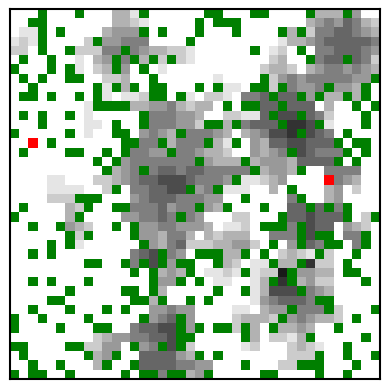

In [41]:
# Пример генерации среды
grid, start, finish = generate_environment(
    n=40,
    m=40,
    p_walk=0.6,
    p_obstacle=0.2,
    number_mud=20, # должно быть пропорционально размерам сетки
)

# Визуализация среды
visualize_array(np.array(grid), [start, finish])

### Реализация Q-learning

<img src="img/q-learning.png" alt="Q-learning" width="600"/>

In [6]:
class QLearning:
    def __init__(self, alpha, epsilon, gamma):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        # Параметр Q-функции: (state, action)
        self.Q = dict()

        # Статистика для анализа: для каждого эпизода -
        # сумма вознаграждений, количество шагов, дошли ли до финиша
        self.stat = []

    # Возвращает текущее значение Q-функции для состояния state и действия action
    # Для терминального состояния - 0
    # Для неинициализированного состояния - 0
    def _get_q_value(self, state, action):
        if Environment.is_terminal(state):
            return 0
        return self.Q.get((state, action), 0)

    # Возвращает максимум Q-функции по всем действиям из состояния state
    def _best_action_value(self, state):
        if Environment.is_terminal(state):
            return 0
        return max(self._get_q_value(state, a) for a in range(4))

    # Выбор действия в состоянии state
    def _choose_action(self, state):
        # С вероятностью epsilon - равновероятно случайное действие
        if random.random() < self.epsilon:
            return randint(0, 3)
        # Иначе - аргмаксимум Q-функции по всем действиям из состояния state
        qs = [self._get_q_value(state, a) for a in range(4)]
        return int(np.argmax(qs))

    def learn(self, max_episodes, max_steps):
        for _ in range(max_episodes):
            # Статистика
            sum_reward = 0
            steps = 0
            final = False

            n, m = randint(5, 7), randint(5, 7)
            env = Environment(
                    n=n,
                    m=m,
                    p_walk=0.5,
                    p_obstacle=random.uniform(0.1, 0.2),
                    number_mud=random.randint(2, 5),
                )
            state = env.get_state()

            self.epsilon = max(0.01, self.epsilon * 0.999)

            for _ in range(max_steps):
                if env.is_terminal(state):
                    final = True
                    break

                action = self._choose_action(state)
                next_state, reward = env.step(action)

                old_q = self._get_q_value(state, action)
                target = reward + self.gamma * self._best_action_value(next_state)

                self.Q[(state, action)] = old_q + self.alpha * (target - old_q)
                state = next_state

                sum_reward += reward
                steps += 1
            
            self.stat.append((sum_reward, steps, final))

#### Оценка модели

Для того, чтобы оценить модель обучения с подкреплением, нужны какие-то метрики. Может быть, есть смысл считать такие.

Во время обучения:
- сумма вознаграждения за эпизод
- доля успешых (агент достиг финиша) эпизодов за последние $x$
- средняя длина успешных эпизодов

После обучения:
- доля успешных эпизодов
- сравнение с оптимальным путём
- средняя длина успешных эпизодов

**Как найти оптимальный путь?**

Если бы не было труднопроходимых поверхностей, можно было бы найти кратчайшее расстояние между точками обычным алгоритмом типа BFS.
Но агент может сделать неизвестное количество шагов в точке со значением $x$ до того, как ему повезёт из неё выйти.

Значит, будем оценивать матожидание кратчайшего пути от старта до финиша.

Матожидание количества шагов, которое нужно сделать, чтобы выйти из точки со значением $x$ ($p = \frac{x}{10}$):
$$E = 1 + \sum \limits_{i = 0}^{\infty} i p^i (1-p) = 1 + \frac{p}{1-p}$$

Оценим так каждую точку, кроме препятствий. Запустим алгоритм поиска кратчайшего пути (алгоритм Дейкстры) из старта.


In [7]:
from heapq import heappush, heappop
INF = 10 ** 9

def expected_shortest_path(env: Environment):
    dist = [[INF] * env.m for _ in range(env.n)]
    si, sj = env.start
    dist[si][sj] = 0

    queue = []
    heappush(queue, (0, si, sj))

    def score(i, j):
        if env.grid[i][j] == 0:
            return 1

        p = env.grid[i][j] / 10
        return 1 + p / (1 - p)

    while len(queue):
        d, i, j = heappop(queue)
        if dist[i][j] != d:
            continue

        for di, dj in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            ni, nj = i + di, j + dj
            if not (0 <= ni < env.n and 0 <= nj < env.m) or env.grid[ni][nj] == OBSTACLE:
                continue

            if dist[ni][nj] > dist[i][j] + score(i, j):
                dist[ni][nj] = dist[i][j] + score(i, j)
                heappush(queue, (dist[ni][nj], ni, nj))

    fi, fj = env.finish
    return dist[fi][fj]

In [8]:
env = Environment(
    n=6,
    m=6,
    p_walk=0.6,
    p_obstacle=0.3,
    number_mud=5, # должно быть пропорционально размерам сетки
) 

# Матожидание кратчайшего пути между стартом и финишем
print(expected_shortest_path(env))

23.333333333333336


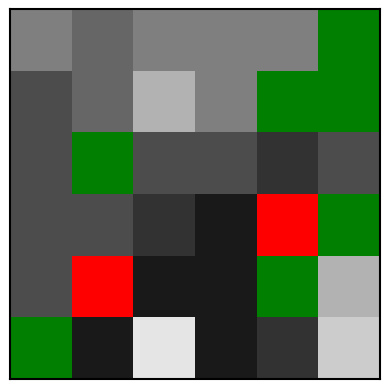

In [9]:
visualize_array(np.array(env.grid), [env.start, env.finish])

#### Пример обучения

In [10]:
q_model = QLearning(alpha=0.1, epsilon=0.3, gamma=1)
q_model.learn(max_episodes=20000, max_steps=300)

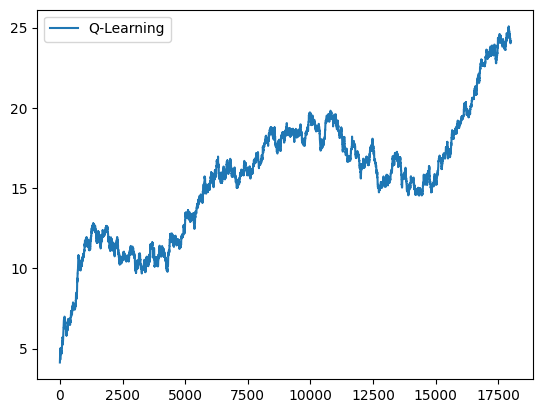

In [34]:
import matplotlib.pyplot as plt

# Анализ статистики из q_model.stat

# График суммарного вознаграждения за эпизод по эпизодам во время обучения
# Скользящее окно, чтобы не было кардиограммы
rewards = np.array([stat[0] for stat in q_model.stat])
window = 2000
q_smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(q_smooth, label='Q-Learning')
plt.legend()

In [12]:
import matplotlib.pyplot as plt
import numpy as np

MAX_STEPS = 500

# Тестовый запуск обученной модели на новой случайной среде
# Возвращает количество шагов агента до достижения финиша (но не более MAX_STEPS)
def try_model(model):
    n, m = 6, 6
    env = Environment(
        n=n,
        m=m,
        p_walk=0.5,
        p_obstacle=random.uniform(0.1, 0.2),
        number_mud=random.randint(2, 5)
    )

    state = env.get_state()
    path = [env.agent_position]

    # Оптимальное действие в state - аргмаксимум Q-функции по всем действиям из state
    def get_optimal_action(state):
        qs = [model._get_q_value(state, a) for a in range(4)]
        return int(np.argmax(qs))

    for _ in range(MAX_STEPS):
        if env.is_terminal(state):
            break
        action = get_optimal_action(state)
        state, _ = env.step(action)
        path.append(env.agent_position)

    return len(path)

(array([462., 257.,  84.,  20.,  25.,   7.,   5.,   2.,   1.,   1.]),
 array([ 1. ,  7.7, 14.4, 21.1, 27.8, 34.5, 41.2, 47.9, 54.6, 61.3, 68. ]),
 <BarContainer object of 10 artists>)

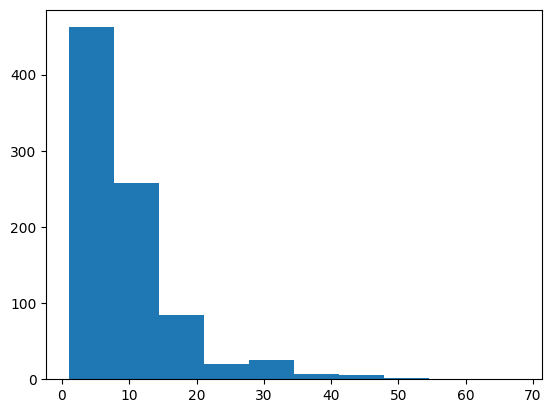

In [13]:
# Количество эпизодов
N = 1000
path_steps = []
cnt_large = 0
for _ in range(N):
    steps = try_model(q_model)
    if steps < MAX_STEPS:
        path_steps.append(steps)
    else:
        cnt_large += 1

path_steps = sorted(path_steps)
plt.hist(path_steps, bins=10)

In [14]:
# Доля эпизодов, для которых не нашёлся путь за MAX_STEPS шагов
print(cnt_large / N)

0.136


---

## SARSA

### Реализация SARSA

<img src="img/sarsa.png" alt="SARSA" width="600"/>

In [15]:
class Sarsa:
    def __init__(self, alpha, epsilon, gamma):
        self.alpha = alpha
        self.epsilon = epsilon
        self.gamma = gamma
        self.Q = dict()

        # Статистика для анализа: для каждого эпизода -
        # сумма вознаграждений, количество шагов, дошли ли до финиша
        self.stat = []

    # Возвращает текущее значение Q-функции для состояния state и действия action
    # Для терминального состояния - 0
    # Для неинициализированного состояния - 0
    def _get_q_value(self, state, action):
        if Environment.is_terminal(state):
            return 0
        return self.Q.get((state, action), 0)

    # Возвращает максимум Q-функции по всем действиям из состояния state
    def _best_action_value(self, state):
        if Environment.is_terminal(state):
            return 0
        return max(self._get_q_value(state, a) for a in range(4))

    # Выбор действия в состоянии state
    def _choose_action(self, state):
        # С вероятностью epsilon - равновероятно случайное действие
        if random.random() < self.epsilon:
            return randint(0, 3)
        # Иначе - аргмаксимум Q-функции по всем действиям из состояния state
        qs = [self._get_q_value(state, a) for a in range(4)]
        return int(np.argmax(qs))

    def learn(self, max_episodes, max_steps):
        for _ in range(max_episodes):
            # Статистика
            sum_reward = 0
            steps = 0
            final = False

            n, m = randint(5, 7), randint(5, 7)
            env = Environment(
                    n=n,
                    m=m,
                    p_walk=0.5,
                    p_obstacle=random.uniform(0.1, 0.2),
                    number_mud=random.randint(2, 5),
                )
            state = env.get_state()
            action = self._choose_action(state)

            self.epsilon = max(0.01, self.epsilon * 0.999)

            for _ in range(max_steps):
                if env.is_terminal(state):
                    final = True
                    break

                next_state, reward = env.step(action)
                next_action = self._choose_action(next_state)

                old_q = self._get_q_value(state, action)
                target = reward + self.gamma *  self._get_q_value(next_state, next_action)

                self.Q[(state, action)] = old_q + self.alpha * (target - old_q)
                state = next_state
                action = next_action

                sum_reward += reward
                steps += 1
            
            self.stat.append((sum_reward, steps, final))

#### Пример обучения

In [29]:
sarsa_model = Sarsa(alpha=0.1, epsilon=0.3, gamma=1)
sarsa_model.learn(max_episodes=20000, max_steps=300)

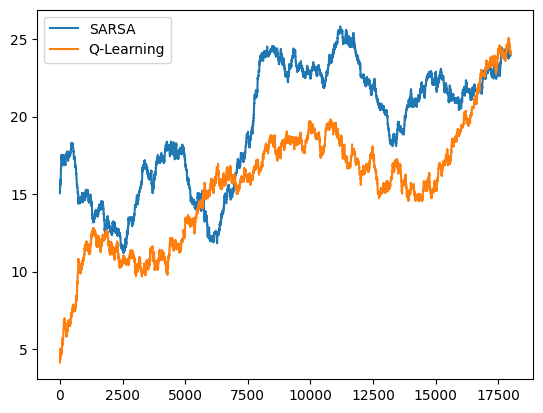

In [33]:
import matplotlib.pyplot as plt

# Анализ статистики из sarsa_model.stat

# График суммарного вознаграждения за эпизод по эпизодам во время обучения
rewards = np.array([stat[0] for stat in sarsa_model.stat])
window = 2000
smooth = np.convolve(rewards, np.ones(window)/window, mode='valid')
plt.plot(smooth, label='SARSA')
plt.plot(q_smooth, label='Q-Learning')
plt.legend()

(array([618., 200.,  63.,  27.,   8.,   3.,   4.,   2.,   1.,   1.]),
 array([ 1. ,  9.2, 17.4, 25.6, 33.8, 42. , 50.2, 58.4, 66.6, 74.8, 83. ]),
 <BarContainer object of 10 artists>)

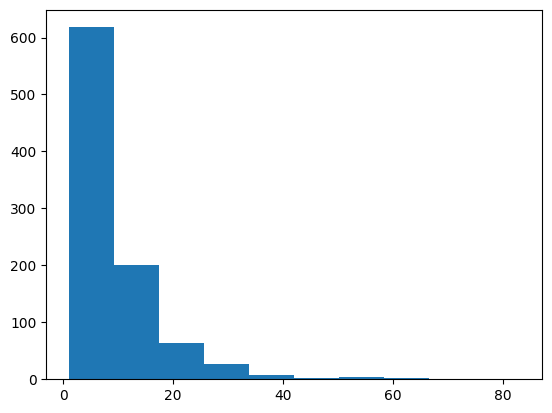

In [31]:
# Количество эпизодов
N = 1000
path_steps = []
cnt_large = 0
for _ in range(N):
    steps = try_model(sarsa_model)
    if steps < MAX_STEPS:
        path_steps.append(steps)
    else:
        cnt_large += 1

path_steps = sorted(path_steps)
plt.hist(path_steps, bins=10)

In [32]:
# Доля эпизодов, для которых не нашёлся путь за MAX_STEPS шагов
print(cnt_large / N)

0.073
